In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("bank-additional-full.csv",sep=";")
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Data processing

In [5]:
#respond variable
data["y"] = data["y"].replace("yes",1)
data["y"] = data["y"].replace("no",0)
#default
data["default"] = data["default"].replace("yes",1)
data["default"] = data["default"].replace("no",0)
data["default"] = data["default"].replace("unknown",2)

#housing
data["housing"] = data["housing"].replace("yes",1)
data["housing"] = data["housing"].replace("no",0)
data["housing"] = data["housing"].replace("unknown",2)

#loan
data["loan"] = data["loan"].replace("yes",1)
data["loan"] = data["loan"].replace("no",0)
data["loan"] = data["loan"].replace("unknown",2)

#month
data["month"] = data["month"].replace("apr",4)
data["month"] = data["month"].replace("aug",8)
data["month"] = data["month"].replace("dec",12)
data["month"] = data["month"].replace("jul",7)
data["month"] = data["month"].replace("jun",6)
data["month"] = data["month"].replace("mar",3)
data["month"] = data["month"].replace("may",5)
data["month"] = data["month"].replace("nov",11)
data["month"] = data["month"].replace("oct",10)
data["month"] = data["month"].replace("sep",9)

#day_of_week
data["day_of_week"] = data["day_of_week"].replace("mon",1)
data["day_of_week"] = data["day_of_week"].replace("tue",2)
data["day_of_week"] = data["day_of_week"].replace("wed",3)
data["day_of_week"] = data["day_of_week"].replace("thu",4)
data["day_of_week"] = data["day_of_week"].replace("fri",5)

data = pd.get_dummies(data, drop_first=True)

Split train and test

In [6]:
y = data['y']
x = data.drop(['y'],axis = 1)
x_train, x_test, y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=20,shuffle = True)

Apply random forest model

In [7]:
rf = RandomForestRegressor(max_depth=7, random_state=20, n_estimators=100)
rf.fit(x_train, y_train)  
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)

In [8]:
shap.initjs()

### Global level interpret

From the Figure 1, we can conclude that the top 2 features that important to the target variable are "duration" and "number of employees". Specifically, for "duration", it indicates that clients with a longer contact duration are more likely to subscribed a term deposit, while for "number of employees", it indicates that clients with lower number of employees are more likely to subscribed a term deposit. 

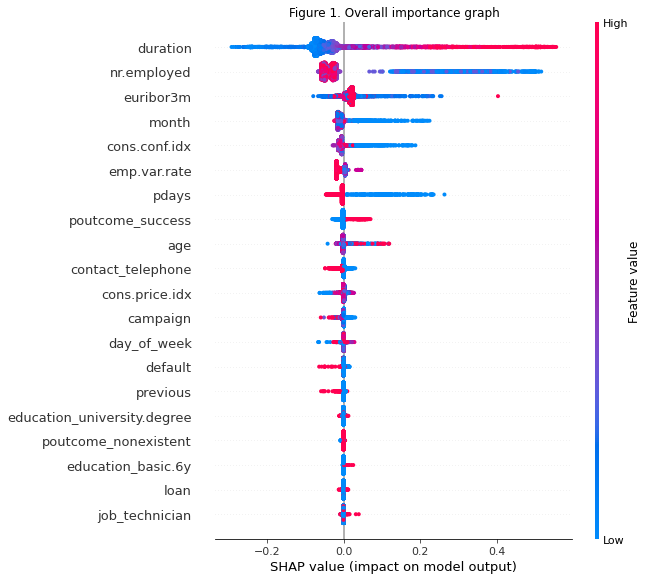

In [9]:
shap.summary_plot(shap_values, x_test,show=False)
plt.title("Figure 1. Overall importance graph")
plt.show()

Then "number of employees" and "education" are checked individually. Figure 2 shows a denpendence graph of "nr.employed", which indicates that 'nr.employed' and 'duration' are correlated. Generally speaking, lower value of 'nr.employed' may occupy a higher duration.

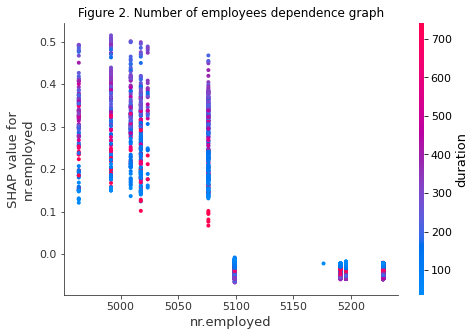

In [10]:
shap.dependence_plot("nr.employed",shap_values, x_test, show = False)
plt.title("Figure 2. Number of employees dependence graph")
plt.show()

In [11]:
value = data[["euribor3m", "duration","nr.employed","pdays","month"]]
value.mean()

euribor3m         3.621291
duration        258.285010
nr.employed    5167.035911
pdays           962.475454
month             6.607896
dtype: float64

In [12]:
shap.force_plot(explainer.expected_value, shap_values[15,:], x_test.iloc[15,:])

From the Figure 1, it can be concluded that education status may not have strong impact on the target value as 'number of employees' as only two sub-categroies of education are presented (education_university.degree; education_basic.6y) and their ranks are low. 

Specifically, for "education_university.degree", Figure 3 indicates that it is related to "consumer price index" however, the relationship between the "university.degree" and "consumer price index" is not quite clear.

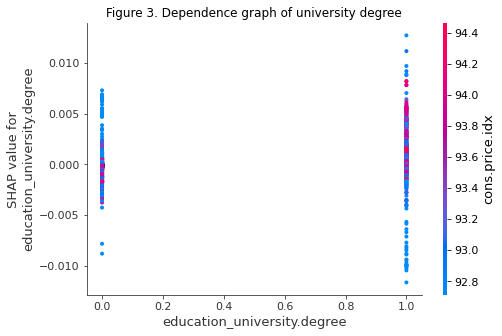

In [13]:
shap.dependence_plot("education_university.degree",shap_values, x_test, show = False)
plt.title("Figure 3. Dependence graph of university degree")
plt.show()

Furthermore, "education_basic.6y" is dependent with "duration". And Figure 4 indicates that most of the clients with 6 years education tend to have shorter contact duration.

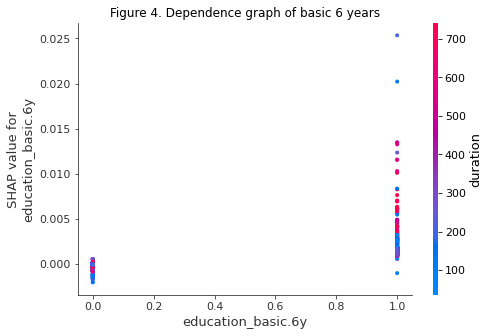

In [14]:
shap.dependence_plot("education_basic.6y",shap_values, x_test, show = False)
plt.title("Figure 4. Dependence graph of basic 6 years")
plt.show()